In [1]:
import numpy as np 
import pandas as pd
import os
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
image_paths = {
    "train_cataract" : [],
    "train_normal" : [],
    "test_cataract" : [],
    "test_normal" : []
}
for dirname, _, filenames in os.walk('/content/drive/MyDrive/processed_images'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        if "train/cataract" in path:
            image_paths["train_cataract"].append(path)
        elif "train/normal" in path:
            image_paths["train_normal"].append(path)
        elif "test/cataract" in path:
            image_paths["test_cataract"].append(path)
        elif "test/normal" in path:
            image_paths["test_normal"].append(path)

In [4]:
len(image_paths["train_normal"])

246

In [5]:
from PIL import Image
from matplotlib import pyplot as plt

size of image : (184, 230, 3)


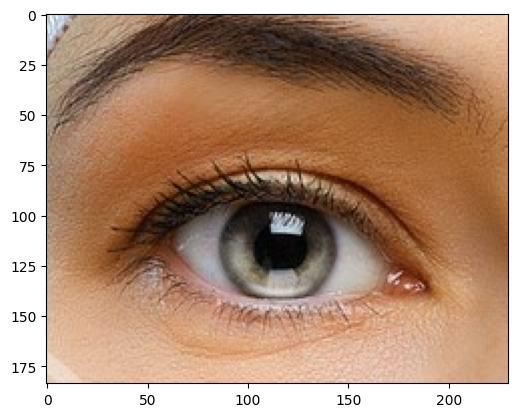

In [6]:
sample_img = np.array(Image.open(image_paths["test_normal"][1]))
print(f"size of image : {np.shape(sample_img)}")
plt.imshow(sample_img)

size of image : (530, 800, 3)


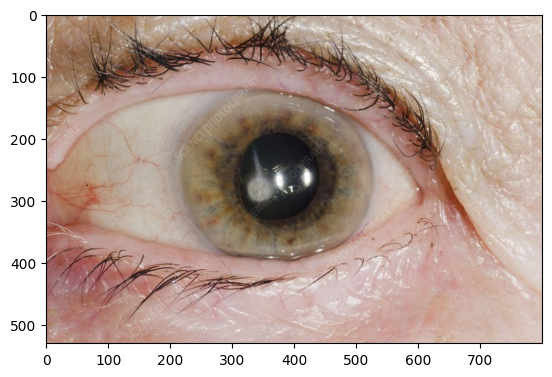

In [7]:
sample_img = np.array(Image.open(image_paths["test_cataract"][0]))
print(f"size of image : {np.shape(sample_img)}")
plt.imshow(sample_img)

In [8]:
training_dir = "/content/drive/MyDrive/processed_images/train"
image_size = (224, 224, 3)
target_size = (224, 224)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size = target_size,
    class_mode = 'binary'
)

Found 491 images belonging to 2 classes.


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers.experimental import RMSprop

In [12]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu',input_shape=image_size),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [14]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer=RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)

In [15]:
history = model.fit_generator(
    train_generator,
    epochs=15
)

<ipython-input-15-d86d002ec681>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/15
16/16 [==============================] - 103s 6s/step - loss: 5.6568 - accuracy: 0.5540
Epoch 2/15
16/16 [==============================] - 65s 4s/step - loss: 0.6601 - accuracy: 0.6619
Epoch 3/15
16/16 [==============================] - 65s 4s/step - loss: 0.4494 - accuracy: 0.7821
Epoch 4/15
16/16 [==============================] - 64s 4s/step - loss: 0.5385 - accuracy: 0.7291
Epoch 5/15
16/16 [==============================] - 77s 5s/step - loss: 0.3782 - accuracy: 0.8411
Epoch 6/15
16/16 [==============================] - 66s 4s/step - loss: 0.4760 - accuracy: 0.8065
Epoch 7/15
16/16 [==============================] - 67s 4s/step - loss: 0.2646 - accuracy: 0.8839
Epoch 8/15
16/16 [==============================] - 68s 4s/step - loss: 0.3144 - accuracy: 0.8758
Epoch 9/15
16/16 [==============================] - 67s 4s/step - loss: 0.3738 - accuracy: 0.8513
Epoch 10/15
16/16 [==============================] - 66s 4s/step - loss: 0.1803 - accuracy: 0.9206
Epoch 11/15
16/16 

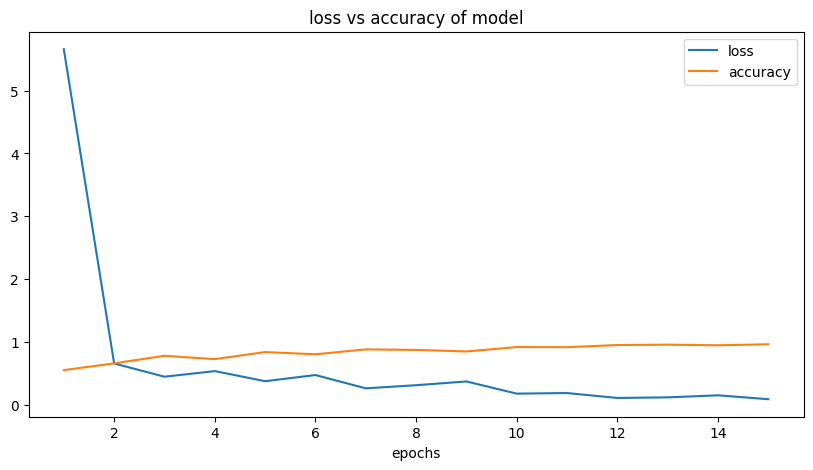

In [16]:
epochs = range(1, 16)
plt.figure(figsize=(10, 5))
plt.title("loss vs accuracy of model")
plt.plot(epochs, history.history['loss'], label='loss')
plt.plot(epochs, history.history['accuracy'], label='accuracy')
plt.grid()
plt.xlabel("epochs")
plt.grid()
plt.legend()

In [17]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('Cataract.tflite', 'wb') as f:
  f.write(tflite_model)

In [18]:
from keras.preprocessing import image

In [19]:
label = train_generator.class_indices
print(label)

{'cataract': 0, 'normal': 1}


1/1 [==============================] - 0s 173ms/step
actual class : cataract
predicted class : cataract


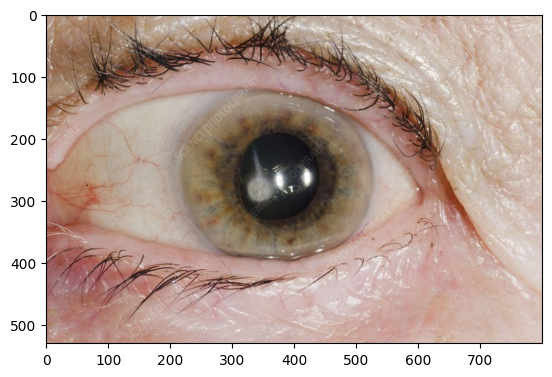

In [20]:
path = image_paths["test_cataract"][0]
img = Image.open(path)
plt.imshow(np.array(img))
img = np.array(img.resize((224, 224)))
img = np.expand_dims(img, axis=0)
pred = model.predict(img)
print("actual class : cataract")
print(f"predicted class : {'normal' if pred[0] > 0.5 else 'cataract'}")

actual class : normal
predicted class : cataract


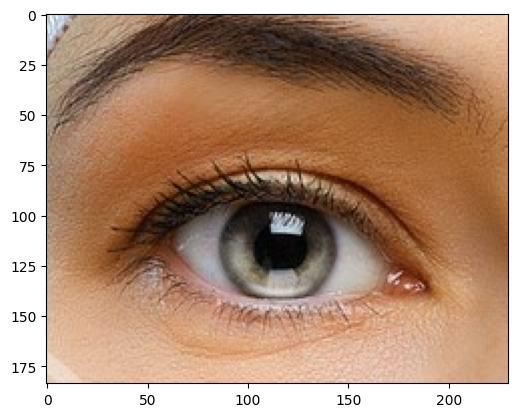

In [23]:
path = image_paths["test_normal"][1]
img = Image.open(path)
plt.imshow(np.array(img))
img = np.array(img.resize((55, 55)))
img = np.expand_dims(img, axis=0)
print("actual class : normal")
print(f"predicted class : {'normal' if pred[0] > 0.5 else 'cataract'}")

In [24]:
def _predict(model, path):
    img = np.array(Image.open(path).resize((224, 224)))
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    if pred[0] > 0.5:
        return 'normal'
    else:
        return 'cataract'

In [25]:
def evaluate(model, normal_path, cataract_path):
    normal_pred = []
    cataract_pred = []
    for normal, cataract in zip(normal_path, cataract_path):
        res_cataract = _predict(model, cataract)
        cataract_pred.append(res_cataract)
        
        res_normal = _predict(model, normal)
        normal_pred.append(res_normal)
    
    return normal_pred, cataract_pred

In [26]:
both_size = min(len(image_paths["test_normal"]), len(image_paths["test_cataract"]))
cataract_test_path = image_paths["test_cataract"][:both_size]
normal_test_path = image_paths["test_normal"][:both_size]
normal_pred, cataract_pred = evaluate(model, image_paths["test_normal"], image_paths["test_cataract"])

1/1 [==============================] - 0s 56ms/step


In [27]:
pred_df = pd.DataFrame()
pred_df["relative_path"] = normal_test_path + cataract_test_path
pred_df["actual_class"] = ["normal"]*len(normal_test_path) + ["cataract"]*len(cataract_test_path)
pred_df["predicted_class"] = normal_pred + cataract_pred

In [28]:
pred_df.tail(20)

,relative_path,actual_class,predicted_class
100,/content/drive/MyDrive/processed_images/test/c...,cataract,cataract
101,/content/drive/MyDrive/processed_images/test/c...,cataract,cataract
102,/content/drive/MyDrive/processed_images/test/c...,cataract,cataract
103,/content/drive/MyDrive/processed_images/test/c...,cataract,cataract
104,/content/drive/MyDrive/processed_images/test/c...,cataract,cataract
105,/content/drive/MyDrive/processed_images/test/c...,cataract,cataract
106,/content/drive/MyDrive/processed_images/test/c...,cataract,cataract
107,/content/drive/MyDrive/processed_images/test/c...,cataract,cataract
108,/content/drive/MyDrive/processed_images/test/c...,cataract,cataract
109,/content/drive/MyDrive/processed_images/test/c...,cataract,cataract


In [29]:
tp = tn = fp = fn = 0
for actual, predicted in zip(list(pred_df['actual_class']), list(pred_df['predicted_class'])):
    if actual == 'normal' and predicted == 'normal':
        tp = tp + 1
    elif actual == 'cataract' and predicted == 'cataract':
        tn = tn + 1
    elif actual == 'normal' and predicted == 'cataract':
        fp = fp + 1
    elif actual == 'cataract' and predicted == 'normal':
        fn = fn + 1

In [30]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

In [31]:
evaluation_summary = pd.DataFrame()
evaluation_summary["accuracy"] = [accuracy]
evaluation_summary["precision"] = [precision]
evaluation_summary["recall"] = [recall]
evaluation_summary["f1"] = [f1]

In [ ]:
evaluation_summary